In [97]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io
from scipy.special import expit #Vectorized sigmoid function

# Neural Networks Learning

In [98]:
data1=scipy.io.loadmat('data/ex4data1.mat')

In [99]:
X=data1['X']
y=data1['y']

In [100]:
print 'X shape: %s' % str(X.shape)
print 'y shape: %s' % str(y.shape)

y_unique, y_counts = np.unique(y, return_counts=True)

print 'y unique elements: %s' % str(y_unique)
print 'y counts elements: %s' % str(y_counts)

X shape: (5000, 400)
y shape: (5000, 1)
y unique elements: [ 1  2  3  4  5  6  7  8  9 10]
y counts elements: [500 500 500 500 500 500 500 500 500 500]


In [142]:
def map_y(y_):
    temp = np.zeros(10)
    temp[ y_ - 1 ] = 1
    return temp

In [148]:
y[0],map_y(y[0]),map_y(y[0]).shape

(array([10], dtype=uint8),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 (10,))

In [124]:
indices = np.random.permutation(len(X))

X_train = X[indices[:int(.9 * len(X))]]
y_train = y[indices[:int(.9 * len(y))]]

X_test = X[indices[int(.9 * len(X)):]]
y_test = y[indices[int(.9 * len(y)):]]

print X_train.shape
print X_test.shape

(4500, 400)
(500, 400)


### Visualise the dataset

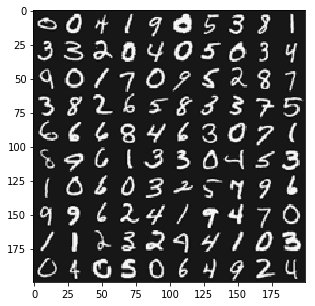

In [103]:
# random select 100 sample from X and draw and image
def display_data_set(X):
    
    nrows, ncols = 10, 10
    w, h = 20, 20
    
    random.seed(123)
    Xsel=X[random.sample(range(X.shape[0]), nrows*ncols)]
    
    img = np.zeros((w*nrows,h*ncols))
    count = 0
    
    for i in range(nrows):
        for j in range(ncols):
            #print i*h,(i+1)*h,j*w,(j+1)*w
            img[i*h:(i+1)*h,j*w:(j+1)*w] = Xsel[count,0:].reshape(w,h).T
            count += 1
            
    plt.imshow(img,cmap = cm.Greys_r)
 
plt.figure( figsize=(5,5))
display_data_set(X)
plt.show()

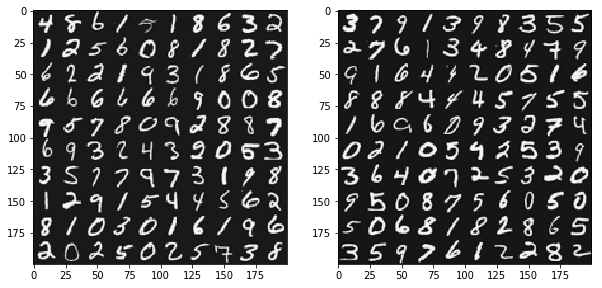

In [177]:
plt.figure( figsize=(10,5))
plt.subplot(121)
display_data_set(X_train)
plt.subplot(122)
display_data_set(X_test)
plt.show()

### Model parameters

In [104]:
param1=scipy.io.loadmat('data/ex4weights.mat')

In [105]:
Theta1=param1['Theta1']
Theta2=param1['Theta2']

print 'Theta1 shape: %s' % str(Theta1.shape)
print 'Theta2 shape: %s' % str(Theta2.shape)

Theta1 shape: (25, 401)
Theta2 shape: (10, 26)


### Feed-forward propagation

In [109]:
def feed_forward(x_, thetas_):
    ll = x_
    for t_ in thetas_:
        ll=np.insert(ll,0,1,axis=0)
        ll = expit(t_.dot(ll)) # First layer activation
    return ll

def prediction(x_,thetas_):
    classes = range(1,10) + [10]
    
    prob=feed_forward(x_, thetas_)
    return classes[prob.argmax()],prob 

def test(x_,thetas_,y_):
    
    pred, prob = prediction(x_, thetas_)

    if pred == y_:
        return True
    else:
        return False
    
def test_all(x_,thetas_, y_):
    
    correct_counter = [0]*10
    n_correct, n_total = 0. , 0.
    incorrect_indices = []
    
    for i in xrange(len(x_)):
        n_total += 1

        if test(x_[i], thetas_, y_[i]):
            n_correct += 1
            correct_counter[ y[i,0] if y[i,0] != 10 else 0 ] += 1

        else: incorrect_indices.append(i)
            
    return n_correct/float(n_total), correct_counter/y_counts.astype('float'), incorrect_indices

In [107]:
feed_forward(X[0], [Theta1, Theta2])

array([  1.12661530e-04,   1.74127856e-03,   2.52696959e-03,
         1.84032321e-05,   9.36263860e-03,   3.99270267e-03,
         5.51517524e-03,   4.01468105e-04,   6.48072305e-03,
         9.95734012e-01])

In [110]:
prediction(X[0], [Theta1, Theta2])

(10, array([  1.12661530e-04,   1.74127856e-03,   2.52696959e-03,
          1.84032321e-05,   9.36263860e-03,   3.99270267e-03,
          5.51517524e-03,   4.01468105e-04,   6.48072305e-03,
          9.95734012e-01]))

In [111]:
test(X[0], [Theta1, Theta2],y[0])

True

### Cost function

In [135]:
def cost_function(thetas_, x_, y_):
    
    cost = 0.
    m = x_.shape[0]
    
    #term1 = np.dot(-y_.T, np.log(h(t_,x_))) # [n_sample,1].T * [n_sample,1  = [1,1]
    #term1 -= np.dot( (1-y_).T, np.log(1-h(t_,x_)) ) # [n_sample, 1].T * [n_sample,1  = [1,1]
    #term1 *= 1/(1.*m)
    #term2 = np.dot(t_.T, t_) # [n_feature,1].T * [n_feature,1] = [1]
    #term2 *= l_/(2.*m)

    for i in xrange(m):
        
        term1 = np.dot(-map_y(y_[i,:]).T, np.log( feed_forward(x_[i,:], thetas_))) 
        term2 = np.dot(-(1-map_y(y_[i,:])).T, np.log( 1 - feed_forward(x_[i,:], thetas_)))
        
        cost += term1+term2
        
    return  cost/(1.*m)

In [144]:
cost_function([Theta1, Theta2], X, y)

0.28762916516131876

### Regularized cost function

In [138]:
def reg_cost_function(thetas_, x_, y_, lambdas_ = 1.):
    
    cost = cost_function(thetas_, x_,y_)
    m = x_.shape[0]
    reg = 0.
    
    for t_ in thetas_:
        reg += np.sum(t_[:,1:]*t_[:,1:]) # Element by element multiplication, not dot product
        
    reg *= lambdas_ / (2.*m)
    
    return cost+reg

In [145]:
reg_cost_function([Theta1, Theta2], X, y, 1.)

0.38376985909092348

## Backpropagation

### Sigmoid gradient

In [17]:
def sig_grad(x_):
    return expit(x_) * (1-expit(x_))

In [18]:
print "Sigmoid gradient for x = %.2f : %.2f" % (0   , sig_grad(0.))
print "Sigmoid gradient for x = %.2f : %.2f" % (100 , sig_grad(100.))
print "Sigmoid gradient for x = %.2f : %.2f" % (-100, sig_grad(-100.))

Sigmoid gradient for x = 0.00 : 0.25
Sigmoid gradient for x = 100.00 : 0.00
Sigmoid gradient for x = -100.00 : 0.00


### Random initialization

In [19]:
eps=.12
W1 = np.random.rand(Theta1.shape[0], Theta1.shape[1]) * 2 * eps - eps
W2 = np.random.rand(Theta2.shape[0], Theta2.shape[1]) * 2 * eps - eps

### Flatten array

In [20]:
def matrix_flatten(thetas_):
    shapes_ = [t.shape for t in thetas_ ]
    flatten_ = [ t.flatten() for t in thetas_ ]
    flatten_ = np.concatenate(flatten_)
    return [flatten_,shapes_]
 
def matrix_reshape(flatten_, shapes_ = [] ):
    matrix_ = [] 
    idx_start, idx_stop = 0, 0
    for i in range(len(shapes_)):
        if i == 0: 
            idx_stop = shapes_[0][0]*shapes_[0][1]
        else:
            idx_start = idx_stop
            idx_stop = idx_start + shapes_[i][0]*shapes_[i][1]
        #print idx_start, idx_stop, idx_stop - idx_start, len(flatten_[idx_start:idx_stop]), len(flatten_)
        matrix_.append(flatten_[idx_start:idx_stop].reshape(shapes_[i]))
    return matrix_

In [21]:
flat_thetas, shapes_thetas = matrix_flatten([Theta1, Theta2])
thetas=matrix_reshape(flat_thetas,shapes_thetas)

## Back propagation

In [149]:
def flat_feed_forward(x_, flat_thetas_, shapes_):

    thetas_=matrix_reshape(flat_thetas_,shapes_)
    
    a = x_
    z_a_layer = []
    
    for t_ in thetas_:
        a = np.insert(a,0,1,axis=0)
        z = t_.dot(a)
        a = expit(z) # First layer activation
        z_a_layer.append((z,a))
        
    return np.array(z_a_layer)


def flat_reg_back_propagation(flat_thetas_, x_, y_, shapes_, lambda_ = 0.):
        
    thetas_=matrix_reshape(flat_thetas_,shapes_)
    
    Delta1 = np.zeros(thetas_[0].shape)
    Delta2 = np.zeros(thetas_[1].shape)

    for i in xrange( len(x_)):
    
        za = flat_feed_forward(x_[i], flat_thetas_, shapes_)
        
        a1 = np.insert(x_[i],0,1,axis=0) # (401,)
        z2 = za[0][0]                    # (25,)
        a2 = za[0][1]                    # (25,)
        z3 = za[1][0]                    # (10,)
        a3 = za[1][1]                    # (10,)
            
        d3 = a3 - map_y(y_[i])# (10,)
        d2 = thetas_[1].T[1:,:].dot(d3)*sig_grad(z2) # (25,)
        
        
        a2 = np.insert(a2,0,1,axis=0) # (26,)
        
        d2 = np.expand_dims(d2,axis=1) # (25,1)
        d3 = np.expand_dims(d3,axis=1) # (10,1)
    
        a1 = np.expand_dims(a1,axis=1) # (401,1)
        a2 = np.expand_dims(a2,axis=1) # (26,1)
    
           
        Delta1 += d2.dot(a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += d3.dot(a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
    
    Delta1 /= float(len(x_))
    Delta2 /= float(len(x_))
    
    # Add Regularization term (The first column should not be regularized!!!)
    Delta1[:,1:] += thetas_[0][:,1:]*float(lambda_)/float(len(x_))
    Delta2[:,1:] += thetas_[1][:,1:]*float(lambda_)/float(len(x_))
    
    return matrix_flatten([Delta1, Delta2])[0]

In [150]:
# This represent the derivate of J(theta) wrt theta!
D = flat_reg_back_propagation(flat_thetas, X,y, shapes_thetas)
D_reg = flat_reg_back_propagation(flat_thetas,X,y, shapes_thetas,1.)

### Cost function with flatten input

In [151]:
def flatten_cost_function(flat_thetas_, x_, y_, shapes_):
    thetas_ = matrix_reshape(flat_thetas_, shapes_)
    return cost_function(thetas_, x_, y_)
    
def flatten_reg_cost_function(flat_thetas_, x_, y_, shapes_, lambdas_ = 0.):
    thetas_ = matrix_reshape(flat_thetas_,shapes_)
    return reg_cost_function(thetas_, x_, y_, lambdas_)

In [152]:
flatten_reg_cost_function(flat_thetas, X, y, shapes_thetas, 1.)

0.38376985909092348

### Gradient check

In [153]:
def grad_check(x_,y_,flat_thetas_, shapes_thetas_):

    epsilon=1.e-4

    for i in xrange(10):
        
        idx = int(np.random.rand()*len(flat_thetas_))
        
        epsvec = np.zeros(flat_thetas_.shape)
        epsvec[idx] = epsilon
    
        cost_p = flatten_reg_cost_function(flat_thetas_+epsvec, x_, y_, shapes_thetas_, 0.)
        cost_m = flatten_reg_cost_function(flat_thetas_-epsvec, x_, y_, shapes_thetas_, 0.)
        
        grad_check = (cost_p - cost_m) / float(2.*epsilon)
        
        print "Element %i \t back prop grad %.10f \t num grad %.10f" % (idx, D[idx], grad_check)

In [154]:
grad_check(X,y,flat_thetas,shapes_thetas)

Element 2127 	 back prop grad -0.0000123868 	 num grad -0.0000123868
Element 354 	 back prop grad -0.0001072520 	 num grad -0.0001072520
Element 3630 	 back prop grad -0.0000000000 	 num grad -0.0000000000
Element 5467 	 back prop grad -0.0001193567 	 num grad -0.0001193567
Element 6334 	 back prop grad -0.0000453840 	 num grad -0.0000453840
Element 9071 	 back prop grad -0.0000592743 	 num grad -0.0000592743
Element 1067 	 back prop grad -0.0001218605 	 num grad -0.0001218605
Element 501 	 back prop grad 0.0000004739 	 num grad 0.0000004739
Element 8278 	 back prop grad -0.0000611295 	 num grad -0.0000611295
Element 1969 	 back prop grad -0.0000299001 	 num grad -0.0000299001


### Learning parameters using fmincg

In [28]:
from scipy import optimize

def train(t_,x_,y_,s_,l_=0.,maxit=100):

    result = optimize.fmin_cg(flatten_reg_cost_function, fprime=flat_reg_back_propagation, x0=t_, \
                              args=(x_, y_,s_,l_), maxiter=maxit, disp=True,\
                              full_output=True)
    
    return result[0], result[1]

### Train the network

In [155]:
eps=.12
W1 = np.random.rand(Theta1.shape[0], Theta1.shape[1]) * 2 * eps - eps
W2 = np.random.rand(Theta2.shape[0], Theta2.shape[1]) * 2 * eps - eps
flat_weights, shapes_weights = matrix_flatten([W1, W2])
result = train(flat_weights, X_train, y_train, shapes_weights, 0., 50)
W1,W2 = matrix_reshape(result[0],shapes_weights)
total_accuracy,partial_accuracy,partial_errors=test_all(X_test,[W1,W2], y_test)
print "Lambda: %.1f \t Max Iter: %i \t Training set accuracy: %0.1f%%"%(0.,50,100*total_accuracy)
print partial_accuracy

         Current function value: 0.198768
         Iterations: 50
         Function evaluations: 120
         Gradient evaluations: 120
Lambda: 0.0 	 Max Iter: 50 	 Training set accuracy: 92.6%
[ 0.926  0.     0.     0.     0.     0.     0.     0.     0.     0.   ]


I do not understand why the *partial_accuracy* array gives the value for the first item only...I am sure the **test** and the **train** samples are well formed.

### Display the first hidden layer

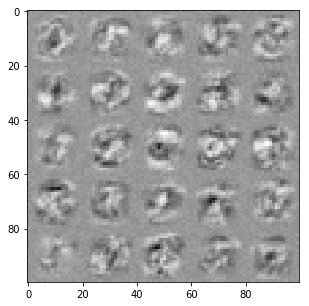

In [31]:
plt.figure( figsize=(5,5))
#display_data_set(Theta1[:,1:])

nrows, ncols = 5, 5
w, h = 20, 20
  
random.seed(123)
  
img = np.zeros((w*nrows,h*ncols))
count = 0
  
for i in range(nrows):
    for j in range(ncols):
        #print i*h,(i+1)*h,j*w,(j+1)*w
        img[i*h:(i+1)*h,j*w:(j+1)*w] = W1[count,1:].reshape(w,h).T
        count += 1
          
plt.imshow(img,cmap = cm.Greys_r)
plt.show()

### Test with different configuration

In [156]:
def train_test(lambda_=0., max_iter_ = 50):
    eps=.12
    W1 = np.random.rand(Theta1.shape[0], Theta1.shape[1]) * 2 * eps - eps
    W2 = np.random.rand(Theta2.shape[0], Theta2.shape[1]) * 2 * eps - eps
    flat_weights, shapes_weights = matrix_flatten([W1, W2])
    result = train(flat_weights, X, y, shapes_weights, lambda_, max_iter_)
    W1,W2 = matrix_reshape(result[0],shapes_weights)
    total_accuracy,partial_accuracy, partial_errors=test_all(X,[W1,W2], y)
    print "Lambda: %.1f \t Max Iter: %i \t Training set accuracy: %0.1f%%"%(lambda_,max_iter_,100*total_accuracy)
    print partial_accuracy

In [157]:
train_test(lambda_=0., max_iter_ = 50)
train_test(lambda_=1., max_iter_ = 50)
train_test(lambda_=1., max_iter_ = 100)    

         Current function value: 0.269652
         Iterations: 50
         Function evaluations: 110
         Gradient evaluations: 110
Lambda: 0.0 	 Max Iter: 50 	 Training set accuracy: 96.9%
[ 0.996  0.982  0.954  0.944  0.968  0.968  0.97   0.976  0.968  0.964]
         Current function value: 0.442477
         Iterations: 50
         Function evaluations: 105
         Gradient evaluations: 105
Lambda: 1.0 	 Max Iter: 50 	 Training set accuracy: 96.3%
[ 0.986  0.984  0.958  0.936  0.972  0.954  0.976  0.956  0.96   0.948]
         Current function value: 0.350037
         Iterations: 100
         Function evaluations: 234
         Gradient evaluations: 234
Lambda: 1.0 	 Max Iter: 100 	 Training set accuracy: 98.8%
[ 0.996  0.992  0.98   0.98   0.986  0.988  0.994  0.986  0.996  0.978]


# Validate model with scikit-learn MLPClassification implementation

In [158]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1., hidden_layer_sizes=(25, 10), 
                    random_state=1, max_iter=200)

In [166]:
clf.fit(X,y)
clf.score(X,y)

1.0

In [167]:
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.92600000000000005

Similar performance to my implementation!